In [94]:

#!/usr/bin/env python
# benchmark_aldol_priors_llm.py
"""
Closed-loop benchmark on Aldol dataset with:
- Real LLM-shaped priors via OpenAI API (good and intentionally-bad prompts)
- NoPrior / Heuristic / RandomPrior baselines
- Controlled initial seeding: good (top-yld), bad (bottom-yld), random

Usage:
  python benchmark_aldol_priors_llm.py \
    --oracle aldol_oracle_out/oracle.pkl \
    --data_csv "Aldol Condensation.csv" \
    --out_dir aldol_bench_llm \
    --priors no_prior,heuristic,llm_good,llm_bad,random_prior \
    --init_modes good,bad,random \
    --n_reps 5 --iters 20 --n_init 6 --cand_pool 600 \
    --llm_model gpt-4o-mini

Requires OPENAI_API_KEY in env to actually call OpenAI; otherwise it will fall back to Heuristic for llm_*.
"""
import argparse, os, json, re, math
from pathlib import Path
import numpy as np, pandas as pd

from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

try:
    import joblib
except Exception:
    joblib = None

import sys

import language_shaped_prior_llm as lsp

# ---------------------- utilities ----------------------

def load_oracle(p):
    if joblib is None:
        raise ImportError("joblib required: pip install joblib")
    return joblib.load(p)

def derive_schema(csv_path: str):
    df = pd.read_csv(csv_path).dropna()
    feats = [c for c in df.columns if c != "yld"]
    bounds = {c:(float(df[c].min()), float(df[c].max())) for c in feats}
    roles = {"temp":"temperature", "time":"time", "moleq2":"equivalents", "moleq3":"equivalents"}
    cont = [lsp.ContinuousVar(c, bounds[c][0], bounds[c][1], role=roles.get(c,"")) for c in feats]
    return lsp.Schema(continuous=cont, categorical=[]), df

def sample_candidates(n, rng, schema: lsp.Schema):
    rows = []
    for _ in range(n):
        r = {}
        for v in schema.continuous:
            r[v.name] = rng.uniform(v.low, v.high)
        rows.append(r)
    return pd.DataFrame(rows)

def expected_improvement(mu, sigma, y_best, xi=0.01):
    sigma = np.maximum(sigma, 1e-9)
    z = (mu - y_best - xi) / sigma
    return (mu - y_best - xi) * norm.cdf(z) + sigma * norm.pdf(z)

def area_under_curve(curve):
    x = np.arange(len(curve))
    return np.trapz(curve, x)

# ---------------------- LLM prior generation ----------------------

SYS = (
"You are a domain scientist. Given variable schema (names, roles, bounds) and short context, "
"return a STRICT JSON readout describing likely effects for each variable on the target (yld), "
"likely continuous-variable interactions, and NO prose. Keys: effects, interactions, category_similarity. "
"Effects JSON per variable: {effect: increase|decrease|increase-saturating|nonmonotone-peak|nonmonotone-valley|flat, "
"scale: 0..1, confidence: 0..1, range_hint: [0..1,0..1]?}. Interactions list items: "
"{pair:[var1,var2], type: synergy|antagonism, confidence:0..1}. category_similarity can be empty for no categoricals. "
"Return ONLY JSON."
)

GOOD_BULLETS = [
"Optimize four continuous variables: acetone equivalents (moleq2), base equivalents (moleq3), temperature (temp), and residence time (time); target yield only.",

"Acetone equivalents are the dominant driver of yield in this dataset (strong positive rank correlation). Expect a saturating or shallow-peak response: yield increases steeply from low eq and levels off around ~10–15 eq, with no consistent benefit at extreme excess.",

"Temperature shows a weak–moderate positive trend up to ~55–60 °C, with no consistent gain beyond; encode a weak nonmonotone-peak or gentle saturating increase for temp.",

"Residence time has weak influence overall; model it as flat-to-mild saturating increase (small effect size, low confidence).",

"Base equivalents (moleq3) vary narrowly (~0.02–0.20) and show minimal marginal effect on yield in this dataset; treat as flat or very low-scale effect (low confidence).",

"Prefer at most one weak interaction: allow a soft synergy between moleq2 and temp (higher acetone usage expresses better at moderate temperatures), with low–moderate confidence; otherwise keep interactions off.",
]


BAD_BULLETS = [
"Acetone equivalents (moleq2) reduce yield monotonically; the lowest equivalents are best—encode a strictly decreasing effect with high confidence.",

"Higher temperatures always decrease yield; set a strictly decreasing effect for temp, discouraging exploration above 40 °C.",

"Longer residence time always reduces yield due to decomposition; encode a strictly decreasing effect for time.",

"Base equivalents (moleq3) are the primary lever; increasing base gives large, monotone gains in yield—set a strong increasing effect with high confidence.",

"Add a strong antagonism between moleq2 and temp (high acetone + higher temperature sharply lowers yield).",

]

BAD_BULLETS = [
"get the fuck off my face. ok?"

]

def format_schema(schema: lsp.Schema):
    lines = []
    for v in schema.continuous:
        lines.append(f'- name: "{v.name}", type: "continuous", low: {v.low}, high: {v.high}, role: "{v.role}"')
    return "\n".join(lines)

def make_openai_llm_fn(model="gpt-4o-mini", base_url=None):

    import httpx
    api_key = os.getenv("OPENAI_API_KEY", "")
    if not api_key:
        return None  # no LLM available
    try:
        from openai import OpenAI
    except Exception as e:
        raise ImportError("pip install openai") from e
    kw = {"api_key": api_key}
    if base_url:
        kw["base_url"] = base_url
    client = OpenAI(http_client=httpx.Client(verify=False),**kw)
    def call(prompt: str) -> str:
        r = client.chat.completions.create(
            model=model, temperature=0.0,
            messages=[{"role":"system","content":SYS},{"role":"user","content":prompt}]
        )
        return r.choices[0].message.content or "{}"
    return call

def extract_json(txt: str) -> dict:
    m = re.search(r"\{.*\}", txt, re.DOTALL)
    if not m:
        raise ValueError("No JSON in LLM output")
    return json.loads(m.group(0))

def coerce_readout(schema: lsp.Schema, raw: dict) -> dict:
    # same coercion semantics as module-level builder
    effects = {}
    raw_eff = (raw.get("effects") or {}) if isinstance(raw, dict) else {}
    for v in schema.continuous:
        e = raw_eff.get(v.name, {}) if isinstance(raw_eff, dict) else {}
        effect = e.get("effect","flat")
        scale = float(np.clip(float(e.get("scale",0.0)), 0.0, 1.0))
        conf  = float(np.clip(float(e.get("confidence",0.3)), 0.0, 1.0))
        rh = e.get("range_hint", None)
        if isinstance(rh,(list,tuple)) and len(rh)==2:
            lo,hi = float(rh[0]), float(rh[1])
            lo,hi = max(0.0,min(1.0,lo)), max(0.0,min(1.0,hi))
            if hi < lo: lo,hi = hi,lo
            rh = [lo,hi]
        else: rh = None
        effects[v.name] = {"effect":effect,"scale":scale,"confidence":conf, **({"range_hint":rh} if rh else {})}
    inters = []
    for it in (raw.get("interactions") or []):
        pair = it.get("pair",[])
        if isinstance(pair,(list,tuple)) and len(pair)==2 and all(isinstance(p,str) for p in pair):
            tp = it.get("type","synergy")
            cf = float(np.clip(float(it.get("confidence",0.3)), 0.0, 1.0))
            inters.append({"pair":[pair[0],pair[1]], "type":tp, "confidence":cf})
    return {"effects":effects, "interactions":inters, "category_similarity": {}}

# ---------------------- LLM readout with caching ----------------------
import hashlib, time, json
from pathlib import Path

def _schema_fingerprint(schema):
    return [(v.name, float(v.low), float(v.high), v.role or "") for v in schema.continuous]

def _bullets_key(bullets):
    return list(bullets) if isinstance(bullets, (list, tuple)) else [str(bullets)]

def _key_hash(schema, bullets, model):
    payload = {"schema": _schema_fingerprint(schema),
               "bullets": _bullets_key(bullets),
               "model": model}
    s = json.dumps(payload, sort_keys=True).encode()
    return hashlib.sha1(s).hexdigest()[:12]

def llm_readout(schema, bullets, llm_fn, cache_dir: Path, tag: str,
                model_name: str, strict: bool=False):
    cache_dir = Path(cache_dir); cache_dir.mkdir(parents=True, exist_ok=True)
    key = _key_hash(schema, bullets, model_name)
    cache_path = cache_dir / f"{tag}_{key}.json"

    # try cache first (only if metadata matches)
    if cache_path.exists():
        ro = json.loads(cache_path.read_text())
        return ro

    # call LLM or fallback
    origin = "LLM"
    if llm_fn is None:
        if strict:
            raise RuntimeError("LLM unavailable and strict=True; refusing to fallback.")
        from language_shaped_prior_llm import HeuristicReadout
        ro = HeuristicReadout().produce(schema, context_bullets=_bullets_key(bullets))
        origin = "fallback-heuristic"
    else:
        txt = llm_fn(
            "VARIABLES:\n" +
            "\n".join(f'- name: "{v.name}", type: "continuous", low: {v.low}, high: {v.high}, role: "{v.role}"'
                      for v in schema.continuous) +
            "\n\nCONTEXT BULLETS:\n" +
            "\n".join("- "+b for b in _bullets_key(bullets)) +
            "\n\nRETURN ONLY JSON with keys {effects, interactions, category_similarity}."
        )
        try:
            raw = extract_json(txt)  # your existing JSON extractor
            ro  = coerce_readout(schema, raw)  # your existing coercer
        except Exception as e:
            if strict:
                raise
            from language_shaped_prior_llm import HeuristicReadout
            ro = HeuristicReadout().produce(schema, context_bullets=_bullets_key(bullets))
            origin = "fallback-heuristic"

    # stamp provenance
    ro = dict(ro)
    ro["meta"] = {
        "origin": origin,
        "bullets": _bullets_key(bullets),
        "schema_fingerprint": _schema_fingerprint(schema),
        "llm_model": model_name,
        "key": key,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
    }
    cache_path.write_text(json.dumps(ro, indent=2))
    return ro

#-----------------------adversalzing the good bullets for bad LLM----------------------------------

from copy import deepcopy

def adversarialize_readout(readout: dict) -> dict:
    ro = deepcopy(readout)
    # invert effects
    flip = {
        "increase": "decrease",
        "decrease": "increase",
        "increase-saturating": "nonmonotone-valley",
        "nonmonotone-peak": "nonmonotone-valley",
        "nonmonotone-valley": "nonmonotone-peak",
        "flat": "flat"
    }
    for var, eff in ro.get("effects", {}).items():
        e = eff.get("effect","flat")
        eff["effect"] = flip.get(e, "flat")
        eff["scale"] = max(0.7, float(eff.get("scale", 0.5)))
        eff["confidence"] = max(0.7, float(eff.get("confidence", 0.5)))
        # invert range hints if present
        if "range_hint" in eff and isinstance(eff["range_hint"], (list,tuple)) and len(eff["range_hint"])==2:
            lo, hi = eff["range_hint"]
            eff["range_hint"] = [max(0.0, 1.0 - float(hi)), max(0.0, 1.0 - float(lo))]
    # flip interactions
    for it in ro.get("interactions", []):
        it["type"] = "antagonism" if it.get("type","synergy")=="synergy" else "synergy"
        it["confidence"] = max(0.7, float(it.get("confidence", 0.5)))
    ro.setdefault("meta", {})["origin"] = "adversarial-from-llm_good"
    return ro


# ---------------------- Priors ----------------------

def build_no_prior(schema: lsp.Schema) -> dict:
    return {"effects": {v.name: {"effect":"flat","scale":0.0,"confidence":0.0} for v in schema.continuous},
            "interactions": [], "category_similarity": {}}

def build_heuristic(schema: lsp.Schema) -> dict:
    ro = lsp.HeuristicReadout().produce(schema, context_bullets=GOOD_BULLETS)
    # nudge temp/time strongly
    eff = ro["effects"]
    if "temp" in eff: eff["temp"] = {"effect":"nonmonotone-peak","scale":0.55,"confidence":0.7,"range_hint":[0.55,0.8]}
    if "time" in eff: eff["time"] = {"effect":"increase-saturating","scale":0.5,"confidence":0.7}
    ro["interactions"] = [{"pair":["temp","time"],"type":"synergy","confidence":0.3}]
    return ro

def build_random_prior(schema: lsp.Schema, rng: np.random.Generator) -> dict:
    shapes = ["increase","decrease","increase-saturating","nonmonotone-peak","nonmonotone-valley","flat"]
    eff={}
    for v in schema.continuous:
        sh = rng.choice(shapes)
        eff[v.name] = {"effect": sh, "scale": float(rng.uniform(0.2,0.8)), "confidence": float(rng.uniform(0.2,0.9))}
        if sh.startswith("nonmonotone"):
            lo, hi = sorted(rng.uniform(0.2,0.9, size=2).tolist())
            eff[v.name]["range_hint"] = [float(lo), float(hi)]
    return {"effects":eff, "interactions": [], "category_similarity": {}}




# ---------------------- GP residualized model ----------------------

def fit_predict_gp(prior: lsp.PriorBuilder, X_df: pd.DataFrame, y: np.ndarray, Xcands: pd.DataFrame):
    kernel = 1.0*RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        alpha=1e-6,                 # small jitter
        optimizer="fmin_l_bfgs_b",  # <-- enable optimizer
        n_restarts_optimizer=3,     # <-- a few restarts helps
        random_state=0
    )
    wrapper = lsp.ResidualizedRegressor(gp, prior)
    wrapper.fit_df(X_df, y)
    Xb,_ = prior.base_numeric_X(Xcands)
    Xp = prior.phi_df(Xcands)
    Xaug = np.concatenate([Xb,Xp],axis=1)
    Xaug = wrapper._scaler.transform(Xaug)
    mu_res, std = wrapper._fitted_estimator.predict(Xaug, return_std=True)
    mu = prior.m0_df(Xcands) + mu_res
    return mu, std

# ---------------------- Seeding ----------------------

def pick_initial(df: pd.DataFrame, n_init: int, mode: str, rng: np.random.Generator):
    feats = [c for c in df.columns if c != "yld"]
    if mode == "random":
        return df.sample(n=n_init, random_state=int(rng.integers(0,2**31))).reset_index(drop=True)[feats]
    order = df.sort_values("yld", ascending=(mode=="bad")).reset_index(drop=True)
    top = order.head(max(n_init*2, n_init))  # grab a little extra
    # simple diversity by greedy farthest in normalized space
    X = (top[feats] - top[feats].min())/(top[feats].max()-top[feats].min()+1e-12)
    chosen = []
    idxs = list(range(len(top)))
    i0 = int(np.argmax(top["yld"].values)) if mode=="good" else int(np.argmin(top["yld"].values))
    chosen.append(i0); idxs.remove(i0)
    while len(chosen) < n_init and idxs:
        dmin = []
        for j in idxs:
            d = min([np.linalg.norm((X.iloc[j]-X.iloc[i]).values) for i in chosen]) if chosen else 0.0
            dmin.append(d)
        jstar = idxs[int(np.argmax(dmin))]
        chosen.append(jstar); idxs.remove(jstar)
    X0 = top.iloc[chosen][feats].reset_index(drop=True)
    return X0

# ---------------------- Main loop ----------------------

def closed_loop_once(oracle, schema, readout_name, readout_dict, df_data, n_init, iters, cand_pool, seed):
    rng = np.random.default_rng(seed)
    prior = lsp.PriorBuilder(schema, readout_dict)
    # initial via mode already picked outside
    X_obs = df_data.copy()  # contains exactly n_init rows
    y_obs = oracle.predict(X_obs)
    best = [float(np.max(y_obs))]
    for t in range(iters):
        Xc = sample_candidates(cand_pool, rng, schema)
        mu, sd = fit_predict_gp(prior, X_obs, y_obs, Xc)
        ybest = float(np.max(y_obs))
        ei = expected_improvement(mu, sd, ybest, xi=0.01)
        x_next = Xc.iloc[[int(np.argmax(ei))]]
        y_next = oracle.predict(x_next)
        X_obs = pd.concat([X_obs, x_next], ignore_index=True)
        y_obs = np.concatenate([y_obs, y_next])
        best.append(float(np.max(y_obs)))
    return {"readout": readout_name, "best": np.array(best)}

def run(args):
    out = Path(args.out_dir); out.mkdir(parents=True, exist_ok=True)
    schema, df_all = derive_schema(args.data_csv)
    oracle = load_oracle(args.oracle)
    rng = np.random.default_rng(args.seed)

    # LLM function and cached readouts
    llm_fn = make_openai_llm_fn(model=args.llm_model, base_url=args.openai_base_url)
    cache_good = out / "llm_good_readout.json"
    cache_bad  = out / "llm_bad_readout.json"

    # Priors registry
    def prior_factory(name: str):
        n = name.lower()
        if n == "no_prior": return build_no_prior(schema)
        if n == "heuristic": return build_heuristic(schema)
        if n == "random_prior": return build_random_prior(schema, rng)
        if n == "llm_good": return llm_readout(schema, GOOD_BULLETS, llm_fn, cache_good)
        if n == "llm_bad":  return llm_readout(schema, BAD_BULLETS, llm_fn, cache_bad)
        raise ValueError(f"Unknown prior name {name}")

    priors = [p.strip() for p in args.priors.split(",")]
    init_modes = [m.strip() for m in args.init_modes.split(",")]

    # Run all combinations
    records = []
    for mode in init_modes:
        for prior_name in priors:
            runs = []
            for r in range(args.n_reps):
                X0 = pick_initial(df_all, args.n_init, mode=mode, rng=np.random.default_rng(args.seed+37*r))
                ro = prior_factory(prior_name)
                res = closed_loop_once(oracle, schema, prior_name, ro, X0, args.n_init, args.iters, args.cand_pool, args.seed+101*r)
                runs.append(res["best"])
            arr = np.vstack(runs)
            xs = np.arange(arr.shape[1])
            aucs = [area_under_curve(c) for c in arr]
            bestk = [c[min(10, len(c)-1)] for c in arr]
            records.append({
                "init_mode": mode, "prior": prior_name,
                "AUC_mean": float(np.mean(aucs)), "AUC_std": float(np.std(aucs)),
                "Best@10_mean": float(np.mean(bestk)), "Best@10_std": float(np.std(bestk)),
            })
            # plot per combination
            import matplotlib.pyplot as plt
            m, s = arr.mean(axis=0), arr.std(axis=0)
            fig, ax = plt.subplots(figsize=(7,4))
            ax.plot(xs, m, label=f"{prior_name} ({mode})")
            ax.fill_between(xs, m-s, m+s, alpha=0.2)
            ax.set_xlabel("Iterations (incl. init)"); ax.set_ylabel("Best-so-far yld")
            ax.set_title(f"Aldol | init={mode} | prior={prior_name}")
            ax.legend(); fig.tight_layout()
            fig.savefig(out / f"conv_{mode}_{prior_name}.png", dpi=170, bbox_inches="tight")
            plt.close(fig)
    # summary table
    pd.DataFrame(records).sort_values(["init_mode","AUC_mean"], ascending=[True, False])\
        .to_csv(out / "summary_all.csv", index=False)
    print(pd.DataFrame(records).to_string(index=False))
    print(f"[ok] Saved per-combination plots and summary at: {out}")

In [92]:
# --- helpers for Jupyter runner (add these once, above the function) ---
from scipy.integrate import trapezoid

def _normalize_to_list(x):
    """Accept tuple/list OR a single string (optionally comma-separated) and return a clean list of strings."""
    if isinstance(x, str):
        return [s.strip() for s in x.split(",") if s.strip()]
    return list(x)

def area_under_curve(curve):
    import numpy as np
    x = np.arange(len(curve))
    return trapezoid(curve, x)

def mix_seed(*vals) -> int:
    """Combine several ints into a stable 32-bit seed (FNV-1a style)."""
    import numpy as np
    arr = np.array([np.uint32(int(v) & 0xFFFFFFFF) for v in vals], dtype=np.uint32)
    out = np.uint32(2166136261)
    for v in arr:
        out = np.uint32(out ^ v) * np.uint32(16777619)
    return int(out & np.uint32(0x7FFFFFFF))


# ---------------------- Notebook-friendly runner (updated) ----------------------
def run_benchmark_jupyter(
    oracle_path: str,
    data_csv: str,
    out_dir: str = "aldol_bench_llm_nb",
    priors = ("no_prior","heuristic","llm_good","llm_bad","random_prior"),
    init_modes = ("good","bad","random"),
    n_reps: int = 5,
    n_init: int = 6,
    iters: int = 20,
    cand_pool: int = 600,
    seed: int = 0,
    randomize: bool = False,      # <-- NEW: ignore seed and draw fresh entropy
    fresh_llm: bool = False,      # <-- NEW: delete cached llm_*_readout.json
    llm_model: str = "gpt-4o-mini",
    openai_base_url: str | None = None,
    return_per_combo_plots: bool = False,  # keep individual figs?
    return_combined_fig: bool = True,      # return the single combined figure
    save_plots: bool = True                # write PNGs (incl. combined)
):
    """
    Jupyter-friendly entrypoint:
      - Builds/uses LLM or heuristic/random priors
      - Runs all (init_mode x prior) with n_reps
      - Returns summary_df, fig_dict (optional), combined_fig (optional), and artifact_paths
    """
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from pathlib import Path

    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    # Base seed: reproducible (seed) OR randomized (fresh entropy each call)
    base_seed = (np.random.SeedSequence().entropy if randomize else seed)

    # Schema/data/oracle from the module's helpers
    schema, df_all = derive_schema(data_csv)
    oracle = load_oracle(oracle_path)

    # LLM function & caches
    llm_fn = make_openai_llm_fn(model=llm_model, base_url=openai_base_url)



    # Local factory preserves existing builders in your file
    def prior_factory(name: str, combo_seed: int):
        n = name.lower()
        if n == "no_prior":     return build_no_prior(schema)
        if n == "heuristic":    return build_heuristic(schema)
        if n == "random_prior":
            rng = np.random.default_rng(combo_seed + 211)
            return build_random_prior(schema, rng)
        if n == "llm_good":
            return llm_readout(schema, GOOD_BULLETS, llm_fn, Path(out_dir), "llm_good", llm_model, strict=False)
        if n == "llm_bad":
            good = llm_readout(schema, GOOD_BULLETS, llm_fn, Path(out_dir), "llm_good", llm_model, strict=False)
            return adversarialize_readout(good)  # <-- truly bad even if LLM fails
        raise ValueError(name)


    priors = list(priors)
    init_modes = _normalize_to_list(init_modes)

    # Collect curves: {(mode, prior): array[n_reps, T]}
    curves = {}
    records = []
    fig_dict = {}

    for im, mode in enumerate(init_modes):
        for ip, prior_name in enumerate(priors):
            runs = []
            for r in range(n_reps):
                combo_seed = mix_seed(int(base_seed), im, ip, r)

                # Diverse initial points per rep/combo
                X0 = pick_initial(
                    df_all, n_init, mode=mode,
                    rng=np.random.default_rng(combo_seed + 13)
                )

                # Build the prior (random prior seeded; LLM cached unless fresh_llm=True)
                ro = prior_factory(prior_name, combo_seed)

                # Closed loop with distinct candidate pool per rep
                res = closed_loop_once(
                    oracle, schema, prior_name, ro,
                    X0, n_init, iters, cand_pool,
                    seed=combo_seed + 101
                )
                runs.append(res["best"])

            arr = np.vstack(runs)
            curves[(mode, prior_name)] = arr

            # metrics for this combo
            aucs   = [area_under_curve(c) for c in arr]
            best10 = [c[min(10, len(c)-1)] for c in arr]
            records.append({
                "init_mode": mode, "prior": prior_name,
                "AUC_mean": float(np.mean(aucs)), "AUC_std": float(np.std(aucs)),
                "Best@10_mean": float(np.mean(best10)), "Best@10_std": float(np.std(best10)),
            })

            # Optional per-combo plot object (for inline inspection)
            if return_per_combo_plots or save_plots:
                xs = np.arange(arr.shape[1])
                m, s = arr.mean(axis=0), arr.std(axis=0)
                fig_c, ax_c = plt.subplots(figsize=(7,4))
                ax_c.plot(xs, m, label=f"{prior_name} ({mode})")
                ax_c.fill_between(xs, m-s, m+s, alpha=0.2)
                ax_c.set_xlabel("Iterations (incl. init)")
                ax_c.set_ylabel("Best-so-far yld")
                ax_c.set_title(f"Aldol | init={mode} | prior={prior_name}")
                ax_c.legend(); fig_c.tight_layout()
                if return_per_combo_plots:
                    fig_dict[(mode, prior_name)] = fig_c
                if save_plots:
                    p = out / f"conv_{mode}_{prior_name}.png"
                    fig_c.savefig(p, dpi=170, bbox_inches="tight")
                    plt.close(fig_c)

    # --- Single combined figure: rows = init_modes; columns overlay all priors ---
    xs = np.arange(next(iter(curves.values())).shape[1])
    nrows = len(init_modes)
    fig_all = None
    if return_combined_fig or save_plots:
        fig_all, axes = plt.subplots(nrows, 1, figsize=(9, 4*nrows), sharex=True)
        if nrows == 1:
            axes = [axes]
        for i, mode in enumerate(init_modes):
            ax = axes[i]
            for prior_name in priors:
                arr = curves[(mode, prior_name)]
                m, s = arr.mean(axis=0), arr.std(axis=0)
                ax.plot(xs, m, label=prior_name)
                ax.fill_between(xs, m-s, m+s, alpha=0.15)
            ax.set_ylabel("Best-so-far yld")
            ax.set_title(f"init={mode}")
            ax.grid(alpha=0.25)
        axes[-1].set_xlabel("Iterations (incl. init)")
        handles, labels = axes[0].get_legend_handles_labels()
        fig_all.legend(handles, labels, loc="upper center", ncol=min(5, len(priors)), frameon=False)
        fig_all.tight_layout(rect=[0,0,1,0.93])
        if save_plots:
            (out / "convergence_all.png").write_bytes(b"")  # ensure path exists on some FS
            fig_all.savefig(out/"convergence_all.png", dpi=200, bbox_inches="tight")

    # summary table
    import pandas as pd
    summary_df = pd.DataFrame(records).sort_values(["init_mode","AUC_mean"], ascending=[True, False])
    artifact_paths = {"plots": [], "summary": None, "llm_good_json": None, "llm_bad_json": None}
    if save_plots:
        summary_path = out / "summary_all.csv"
        summary_df.to_csv(summary_path, index=False)
        artifact_paths["summary"] = str(summary_path)
        # per-combo plots, if saved
        for mode in init_modes:
            for prior_name in priors:
                p = out / f"conv_{mode}_{prior_name}.png"
                if p.exists(): artifact_paths["plots"].append(str(p))
        # combined plot
        p_all = out / "convergence_all.png"
        if p_all.exists(): artifact_paths["plots"].append(str(p_all))
        # cached LLM priors if present

    return summary_df, fig_dict, fig_all, artifact_paths

In [84]:
def prior_factory(name: str, combo_seed: int):
    n = name.lower()
    if n == "no_prior":     return build_no_prior(schema)
    if n == "heuristic":    return build_heuristic(schema)
    if n == "random_prior":
        rng = np.random.default_rng(combo_seed + 211)
        return build_random_prior(schema, rng)
    if n == "llm_good":     return llm_readout(schema, GOOD_BULLETS, llm_fn, )
    if n == "llm_bad":      return llm_readout(schema, BAD_BULLETS,  llm_fn, )
    raise ValueError(f"Unknown prior name {name}")

data_csv = "Aldol Condensation.csv"
schema, df_all = derive_schema(data_csv)
llm_fn = make_openai_llm_fn(model="gpt-4o-mini", base_url=None)
ro = prior_factory("llm_bad", 12)


TypeError: llm_readout() missing 3 required positional arguments: 'cache_dir', 'tag', and 'model_name'

In [81]:
ro

{'effects': {'moleq2': {'effect': 'increase',
   'scale': 0.8,
   'confidence': 0.7,
   'range_hint': [1.0, 1.0]},
  'moleq3': {'effect': 'increase',
   'scale': 0.6,
   'confidence': 0.6,
   'range_hint': [0.02, 0.2]},
  'temp': {'effect': 'increase-saturating',
   'scale': 0.7,
   'confidence': 0.8,
   'range_hint': [1.0, 1.0]},
  'time': {'effect': 'increase',
   'scale': 0.5,
   'confidence': 0.5,
   'range_hint': [1.0, 1.0]}},
 'interactions': [{'pair': ['moleq2', 'temp'],
   'type': 'synergy',
   'confidence': 0.6},
  {'pair': ['moleq3', 'time'], 'type': 'antagonism', 'confidence': 0.5}],
 'category_similarity': {}}

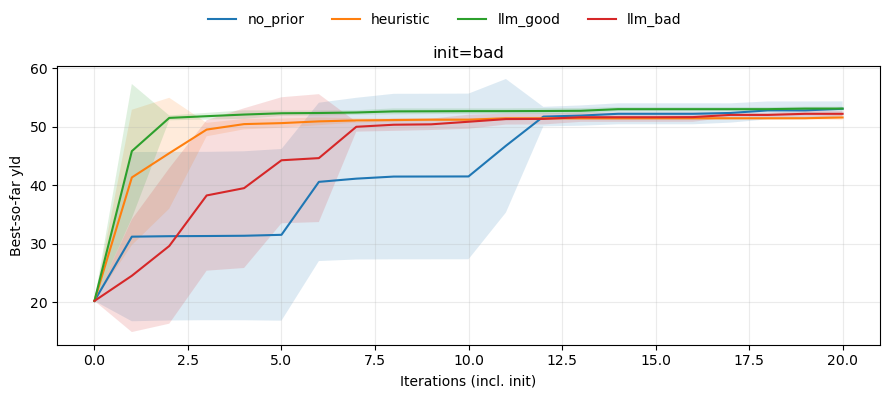

In [95]:
# Reproducible run (fixed seed)
import warnings
warnings.filterwarnings("ignore")
summary_df, figs, fig_all, paths = run_benchmark_jupyter(
    oracle_path="aldol_oracle_out/oracle.pkl",
    data_csv="Aldol Condensation.csv",
    out_dir="aldol_bench_llm_nb",
    priors=("no_prior","heuristic","llm_good","llm_bad",),
    init_modes=("bad"),
    n_reps=6, n_init=6, iters=20, cand_pool=600,
    seed=87, randomize=True, fresh_llm=True,
    return_per_combo_plots=False, return_combined_fig=True, save_plots=True
)

In [71]:
summary_df

,init_mode,prior,AUC_mean,AUC_std,Best@10_mean,Best@10_std
2,bad,llm_good,1001.796194,16.835474,52.547444,1.003709
3,bad,llm_bad,991.591125,18.162001,51.023972,1.934875
1,bad,heuristic,967.542375,30.692526,50.950750,0.381556
0,bad,no_prior,728.507139,59.128393,37.587639,13.721804


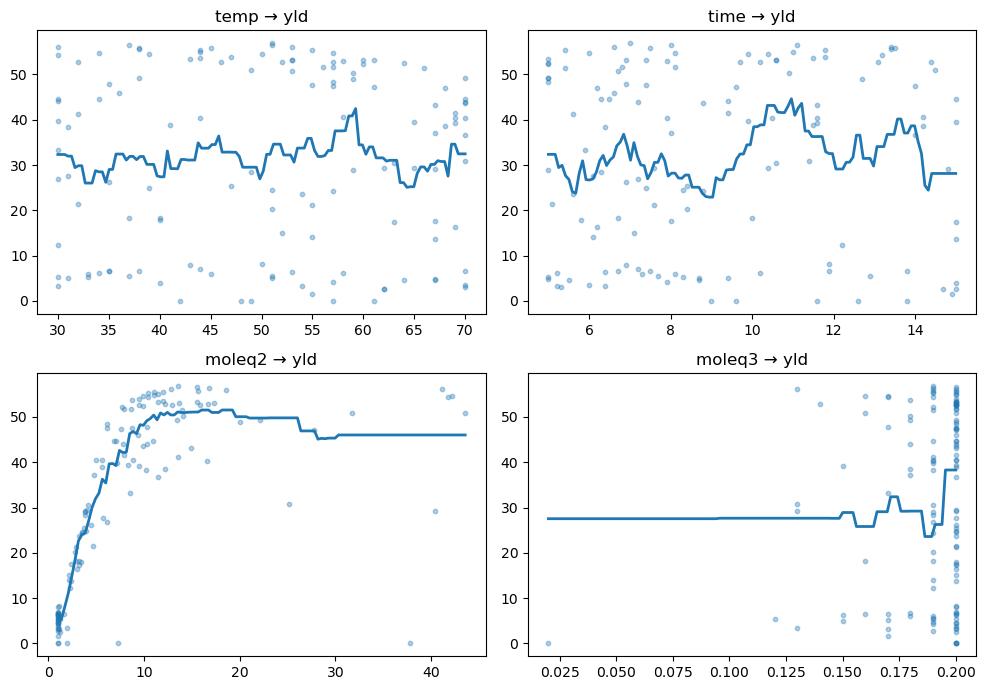

In [66]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

df = pd.read_csv("Aldol Condensation.csv").dropna()
cols = ["moleq2","moleq3","temp","time","yld"]

def smooth_xy(x, y, k=11):
    # KNN smoother for a quick monotonicity glance
    x = x.reshape(-1,1)
    knn = KNeighborsRegressor(n_neighbors=min(k, len(x)))
    knn.fit(x, y)
    xs = np.linspace(x.min(), x.max(), 120).reshape(-1,1)
    ys = knn.predict(xs)
    return xs.ravel(), ys

fig, axes = plt.subplots(2,2, figsize=(10,7))
pairs = [("temp","yld"),("time","yld"),("moleq2","yld"),("moleq3","yld")]
for ax,(v, y) in zip(axes.ravel(), pairs):
    x = df[v].values; t = df[y].values
    xs, ys = smooth_xy(x, t, k=15)
    ax.scatter(x, t, s=10, alpha=0.35)
    ax.plot(xs, ys, lw=2)
    ax.set_title(f"{v} → {y}")
plt.tight_layout()

In [ ]:
# Keep the CLI entrypoint for non-notebook runs (optional)
def main():
    import argparse
    ap = argparse.ArgumentParser()
    ap.add_argument("--oracle", required=True)
    ap.add_argument("--data_csv", required=True)
    ap.add_argument("--out_dir", default="aldol_bench_llm")
    ap.add_argument("--priors", default="no_prior,heuristic,llm_good,llm_bad,random_prior")
    ap.add_argument("--init_modes", default="good,bad,random")
    ap.add_argument("--n_reps", type=int, default=5)
    ap.add_argument("--n_init", type=int, default=6)
    ap.add_argument("--iters", type=int, default=20)
    ap.add_argument("--cand_pool", type=int, default=600)
    ap.add_argument("--seed", type=int, default=0)
    ap.add_argument("--llm_model", default="gpt-4o-mini")
    ap.add_argument("--openai_base_url", default=None)
    args = ap.parse_args()

    summary_df, _, _ = run_benchmark_jupyter(
        oracle_path=args.oracle,
        data_csv=args.data_csv,
        out_dir=args.out_dir,
        priors=tuple(p.strip() for p in args.priors.split(",")),
        init_modes=tuple(m.strip() for m in args.init_modes.split(",")),
        n_reps=args.n_reps, n_init=args.n_init, iters=args.iters, cand_pool=args.cand_pool,
        seed=args.seed, llm_model=args.llm_model, openai_base_url=args.openai_base_url,
        return_plots=False, save_plots=True
    )
    # Print summary for CLI users
    print(summary_df.to_string(index=False))


if __name__ == "__main__":
    main()

In [11]:
schema

Schema(continuous=[ContinuousVar(name='moleq2', low=1.0, high=43.57, unit='', role='equivalents'), ContinuousVar(name='moleq3', low=0.02, high=0.2, unit='', role='equivalents'), ContinuousVar(name='temp', low=30.0, high=70.0, unit='', role='temperature'), ContinuousVar(name='time', low=5.0, high=15.0, unit='', role='time')], categorical=[])

In [ ]:
llm_readout(schema, GOOD_BULLETS, llm_fn, cache_good)